<a href="https://colab.research.google.com/github/Xixianghu202124213/Capstone/blob/main/ARIMAX_log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF
import numpy as np
%matplotlib inline
import csv
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


           MATERIAL_NUMBER PLANT  QUANTITY
DATE                                      
2015-01-05               H    X2         0
2015-01-06               H    X2         5
2015-01-07               H    X2         2
2015-01-08               H    X2       260
2015-01-09               H    X2         9
...                    ...   ...       ...
2020-01-01               H    X2         0
2020-01-02               H    X2        33
2020-01-03               H    X2        27
2020-01-04               H    X2         0
2020-01-05               H    X2         0

[1827 rows x 3 columns]


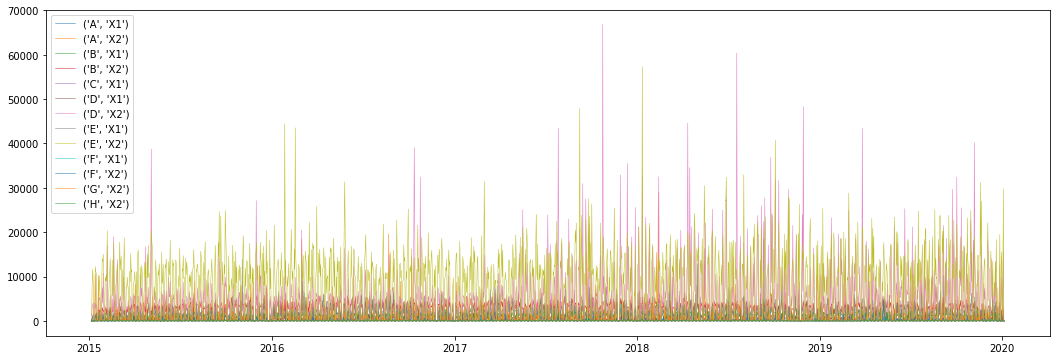

In [ ]:

csvfile = open('/content/drive/MyDrive/Data/historical_orders.csv','r')
reader = [each for each in csv.DictReader(csvfile, delimiter=';')]
df = pd.DataFrame(reader)

df["DATE"]=pd.to_datetime(df["DATE"],format="%d.%m.%Y")
df.set_index('DATE',inplace=True)
groups=df.groupby(["MATERIAL_NUMBER","PLANT"])
group_list=list(groups)
group_list
from pandas import DataFrame
ax,fig=plt.subplots(figsize=(18,6))
series=DataFrame()
for key,df in groups:
    series=df.copy()
    series.iloc[:,2]=series.iloc[:,2].astype(int)
    plt.plot(series.index,series.iloc[:,2],linewidth=0.5,label=key)
    plt.legend()
   # print(type(df))
print(series)

#for i in range(len(group_list)):


In [ ]:
GDP=pd.read_csv('/content/drive/MyDrive/Data/GDP.csv')
GDP.columns
GDP.set_index('0',inplace=True)
GDP=GDP[(GDP.index>='2015-01-05')&(GDP.index<='2020-01-05')]
GDP.index.name=None

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
workday=pd.read_csv('/content/drive/MyDrive/Data/workday.csv')
train_size=int(len(df)*0.9)
workday.set_index('DATE',inplace=True)
workday.index=workday.index.astype('datetime64[ns]')
work_train=workday[0:train_size]
work_test=workday[train_size:]

In [ ]:
def ARIMA_Model(timeseries,order):
    model = ARIMA(timeseries,exog=work_train,order=order)
    return model.fit()

In [ ]:
def log(timeseries):
  timeseries_log=np.log(timeseries).replace(float("-inf"), 0)
  return timeseries_log

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model_method2(timeseries, arima_order):
  train_size = int(len(timeseries)*0.9)
  train, test = timeseries[0:train_size],timeseries[train_size:]
  rmse=float("inf")
  try:

    model = ARIMA_Model(train,arima_order)
    fit_seq = model.fittedvalues
    rmse = mean_squared_error(train, fit_seq,squared=False)
  except:
    pass
  return rmse

In [ ]:
def gridsearch(timeseries):
  series_pdq=[]
  series_mse=[]
  train_size=int(len(timeseries)*0.9)
  train=timeseries[0:train_size]
  test=timeseries[train_size:]
  best_score = float("inf")
  best_pdq=None
  for p in range(8):
    for d in range(3):
        for q in range(8):  
          order=(p,d,q)
          #print(str(order))
          try:
            rmse=evaluate_model_method2(timeseries,order)
            if rmse<best_score:
              
              best_score=rmse
              best_pdq=order
              print("RMSE",best_pdq,best_score)
          except:
              pass
  return best_pdq

In [ ]:
def model_fit(seasonal,trend,residual,tr_pdq,re_pdq):
  train_size=int(len(trend)*0.9)
  test=seasonal[train_size:]

  tr_p,tr_d,tr_q=tr_pdq[0],tr_pdq[1],tr_pdq[2]
  trend_model = ARIMA_Model(trend[0:train_size],(tr_p,tr_d,tr_q))

  trend_fit_seq = trend_model.fittedvalues

  re_p,re_d,re_q=re_pdq[0],re_pdq[1],re_pdq[2]
  residual_model = ARIMA_Model(residual[0:train_size],(re_p,re_d,re_q))
  residual_fit_seq = residual_model.fittedvalues

  fit_seq = pd.Series(seasonal[0:train_size], index=seasonal[0:train_size].index)
  fit_seq = fit_seq.add(trend_fit_seq, fill_value=0)
  fit_seq = fit_seq.add(residual_fit_seq, fill_value=0)

  trend_predict_seq = trend_model.predict(start='2019-07-07',end='2019-08-07',exog=work_test[0:32],dynamic=True)
  residual_predict_seq = residual_model.predict(start='2019-07-07',end='2019-08-07',exog=work_test[0:32],dynamic=True)
  seasonal_predict_seq=seasonal['2018-07-01':'2018-08-01']
  
  seasonal_predict_seq.index = test[0:32].index
  predict_seq = pd.Series(seasonal_predict_seq, index=seasonal_predict_seq.index)
  
  predict_seq = predict_seq.add(trend_predict_seq, fill_value=0)
  print(len(predict_seq))
  predict_seq = predict_seq.add(residual_predict_seq, fill_value=0)


  return fit_seq,predict_seq


In [ ]:
def pre_month(sequence,title,test,tr_pdq,re_pdq):
  rmse = mean_squared_error(test[0:32], sequence,squared=False)
  wape=WAPE(sequence,test[0:32])
  plt.figure(figsize=(20, 8))
  plt.plot(sequence, color='red', label='predict_seq')
  plt.plot(test[0:32], color='blue', label='test_seq')
  plt.legend(loc='best')
  plt.title("Trend Model:"+str(tr_pdq) +" Residual Model: "+str(re_pdq)+"  RMSE: %f"%(rmse,))
  plt.suptitle(str(title)+"MONTH")
  name="/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/ARIMAX_Plot(log)(Workday)/"+str(title)+'_predict(Month).png'
  plt.savefig(name)
  plt.show()
  return rmse,wape


In [ ]:
def pre_week(sequence,title,test,tr_pdq,re_pdq):
  rmse = mean_squared_error(test[0:8], sequence,squared=False)
  wape=WAPE(sequence,test[0:8])
  plt.figure(figsize=(20, 8))
  plt.plot(sequence, color='red', label='predict_seq')
  plt.plot(test[0:8], color='blue', label='test_seq')
  plt.legend(loc='best')
  plt.title("Trend Model:"+str(tr_pdq) +" Residual Model: "+str(re_pdq)+"  RMSE: %f"%(rmse,))
  plt.suptitle(str(title)+"WEEK")
  name="/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/ARIMAX_Plot(log)(Workday)/"+str(title)+'_predict(week).png'
  plt.savefig(name)
  plt.show()
  return rmse,wape

In [ ]:
def fit_plot(sequence,title,train,tr_pdq,re_pdq):
  train_size=int(len(train)*0.9)
  wape=WAPE(sequence,train)
  #mae=np.mean(np.abs(sequence.values-train))
  rmse = mean_squared_error(train, sequence,squared=False)
  plt.figure(figsize=(20, 8))
  plt.plot(sequence[len(sequence)-365:len(sequence)], color='red', label='fit_seq')
  plt.plot(train[len(sequence)-365:len(sequence)], color='blue', label='original_seq')
  plt.legend(loc='best')
  plt.title("Trend Model:"+str(tr_pdq) +" Residual Model: "+str(re_pdq)+"  RMSE: %f"%(rmse,))
  plt.suptitle(title)
  name="/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/ARIMAX_Plot(log)(Workday)/"+str(title)+'_month_simulation.png'
  plt.savefig(name)
  plt.show()
  return rmse,wape

In [ ]:
def recover(series):
  recover_seq= np.exp(series)
  recover_seq.dropna(inplace=True)
  return recover_seq

In [ ]:
def WAPE(fit,seq):
  x=(fit-seq).abs().sum()/(seq.abs().sum())
  return x

('A', 'X1')
('A', 'X2')
('B', 'X1')
('B', 'X2')
RMSE (0, 0, 0) 0.49109165630709495
RMSE (0, 0, 1) 0.33216528015885327
RMSE (0, 0, 3) 0.23876902324896335
RMSE (0, 0, 5) 0.23571103360339327
RMSE (0, 0, 6) 0.16895401536507315
RMSE (0, 0, 7) 0.16861700924886097
RMSE (1, 0, 6) 0.16859217130899082
RMSE (1, 0, 7) 0.16791315014865618
RMSE (2, 0, 7) 0.16776323702967763
RMSE (4, 0, 7) 0.16769985941449442
RMSE (5, 0, 7) 0.16766738806514783
RMSE (6, 0, 7) 0.1674874801060578
RMSE (7, 0, 7) 0.16745548291360318
RMSE (0, 0, 0) 1.0438850345962722
RMSE (0, 0, 1) 0.8676496129590705
RMSE (0, 0, 2) 0.8209917434081038
RMSE (3, 0, 1) 0.781570318935479
32


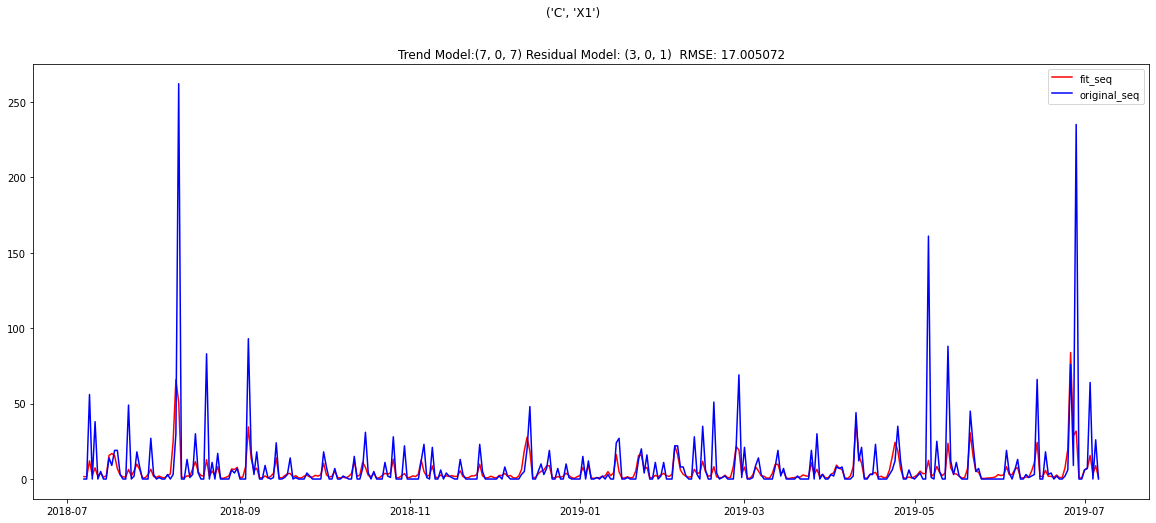

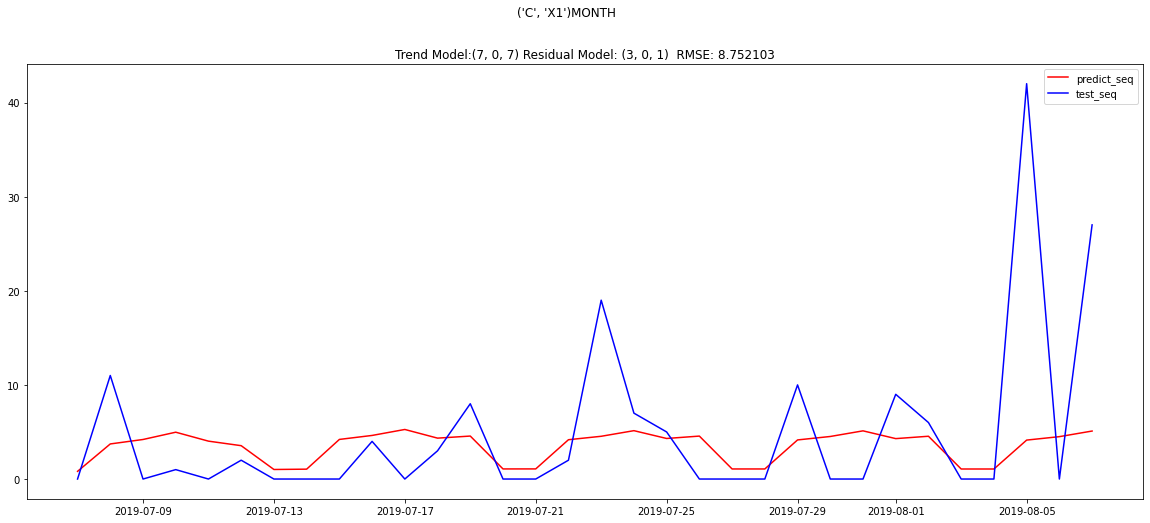

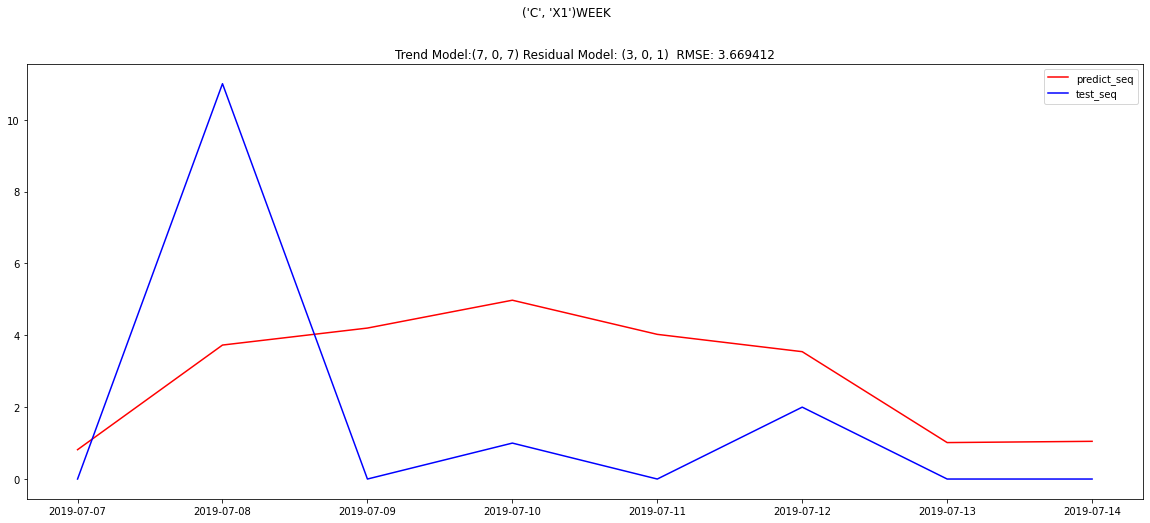

RMSE (0, 0, 0) 0.499455942036484
RMSE (0, 0, 1) 0.3397190073970683
RMSE (0, 0, 4) 0.2503570243964399
RMSE (0, 0, 6) 0.20962594604579504
RMSE (0, 0, 7) 0.2085131040062812
RMSE (3, 0, 6) 0.20845650130359744
RMSE (3, 0, 7) 0.20842627582180184
RMSE (4, 0, 6) 0.2083725440934058
RMSE (7, 0, 6) 0.2077270495111652
RMSE (0, 0, 0) 1.0023259316132533
RMSE (0, 0, 1) 0.8861985926346905
RMSE (0, 0, 2) 0.8065153772677965
RMSE (0, 0, 3) 0.8029918770150588
RMSE (1, 0, 5) 0.716052488932038
RMSE (1, 0, 6) 0.7091789432147505
RMSE (2, 0, 7) 0.7047081531357196
32


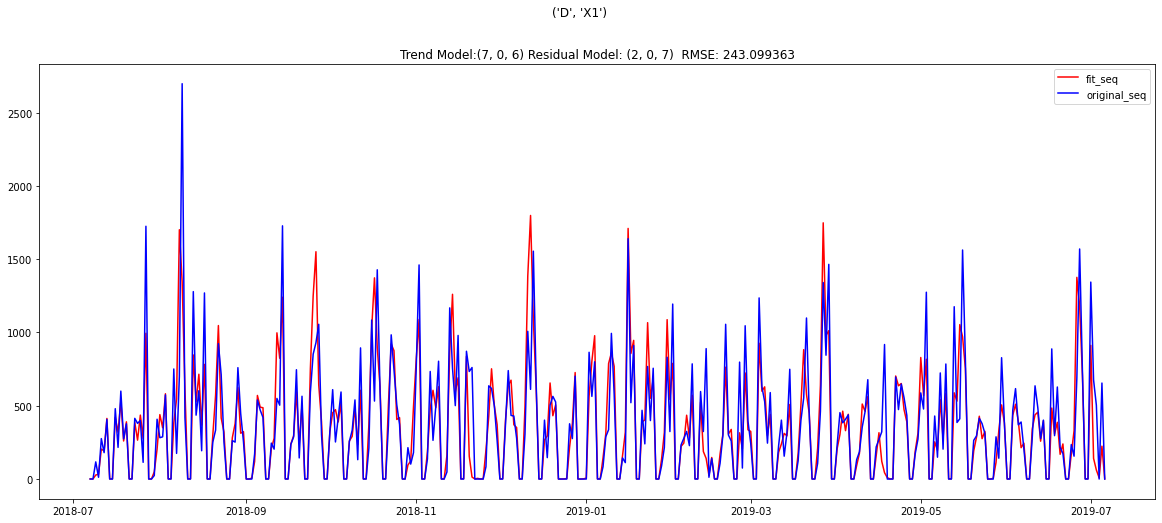

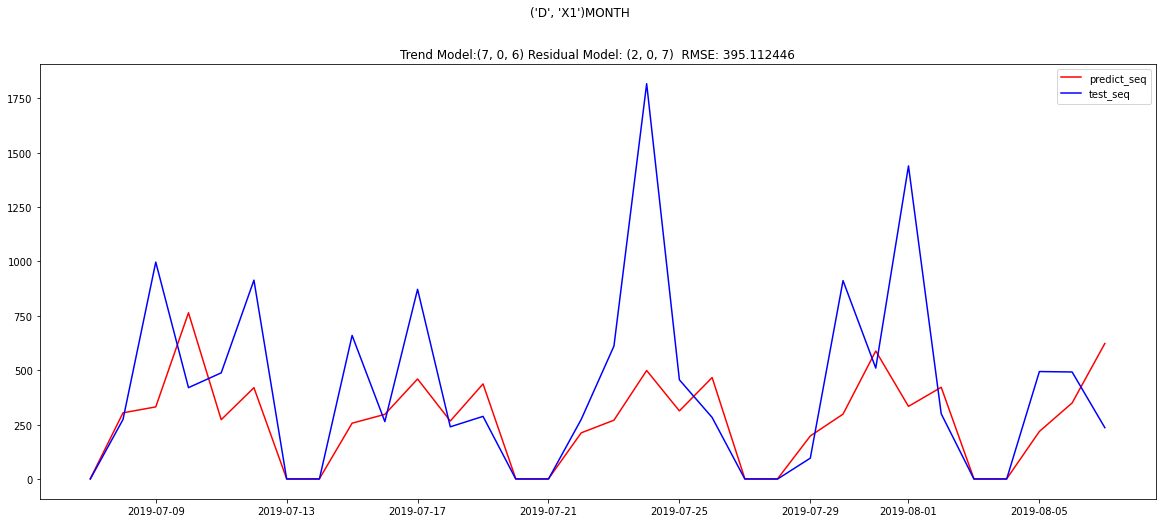

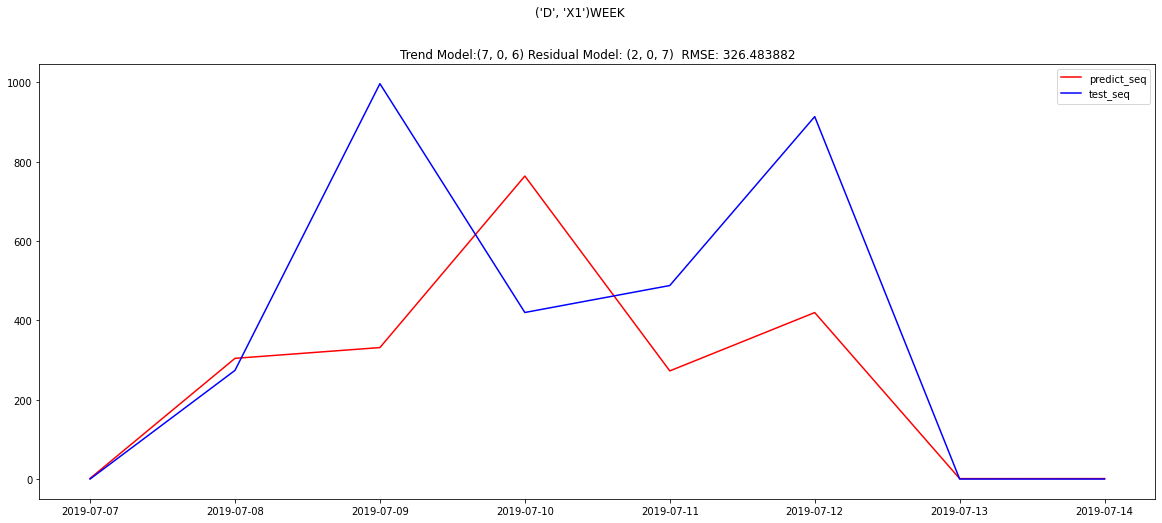

RMSE (0, 0, 0) 0.759158553020972
RMSE (0, 0, 1) 0.5067674683795718
RMSE (0, 0, 3) 0.3645546123960568
RMSE (0, 0, 5) 0.3633937528174567
RMSE (0, 0, 6) 0.31168021272864954
RMSE (1, 0, 6) 0.3116781757924435
RMSE (2, 0, 7) 0.3114525321388503
RMSE (4, 0, 7) 0.3113302675666361
RMSE (6, 0, 7) 0.3112096515514673
RMSE (7, 0, 6) 0.3096282230360379
RMSE (0, 0, 0) 1.3012138019188662
RMSE (0, 0, 1) 1.1397405585300389
RMSE (0, 0, 2) 1.0428286486974594
RMSE (0, 0, 3) 1.040346904745135
RMSE (1, 0, 5) 0.9277465607837619
RMSE (1, 0, 7) 0.9272911085690452
RMSE (2, 0, 7) 0.926991116972548
RMSE (5, 0, 2) 0.9236932495524863
RMSE (6, 0, 3) 0.9223295972776411
RMSE (7, 0, 5) 0.9201575755492115
32


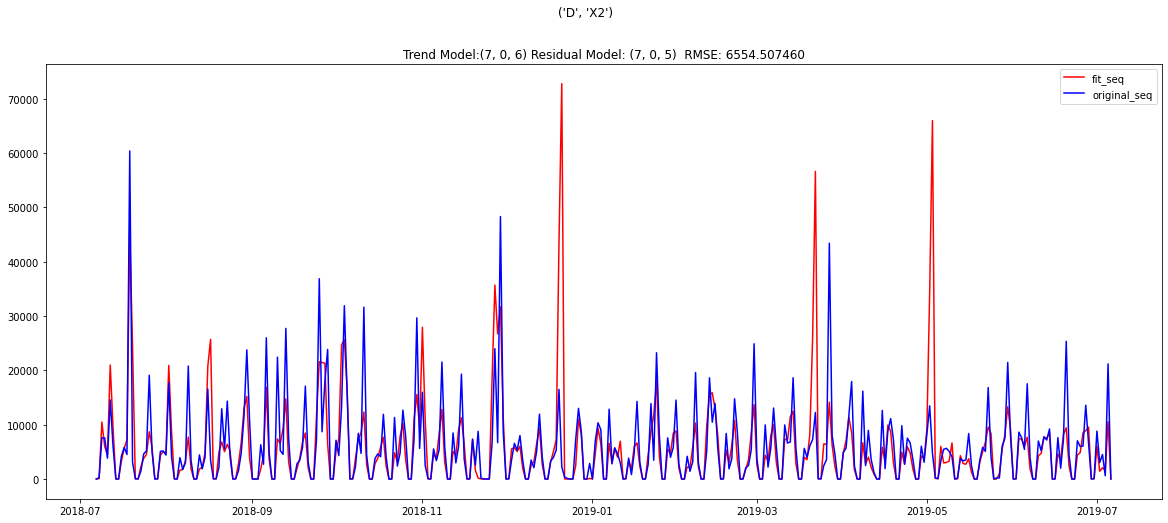

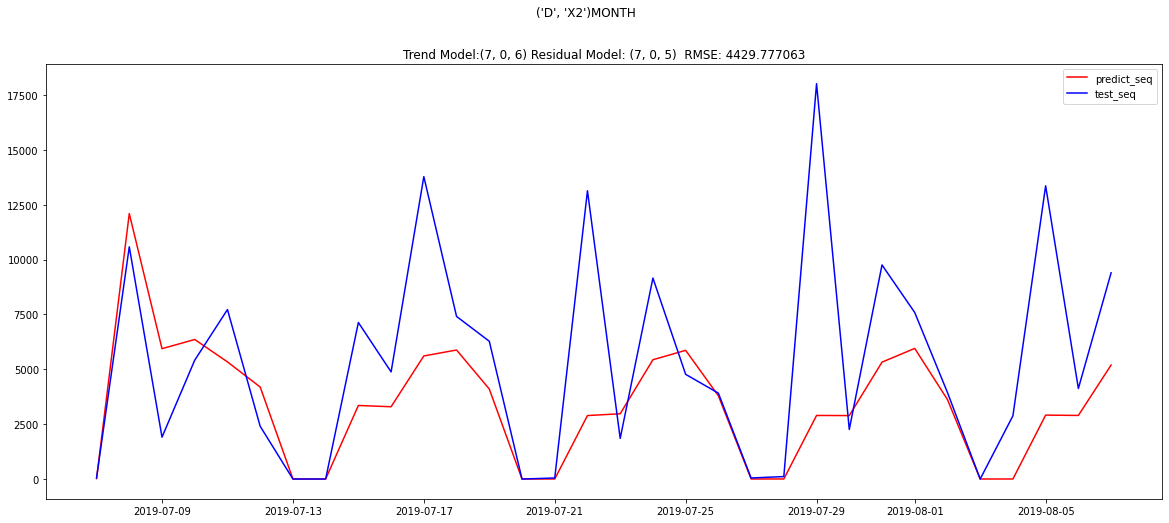

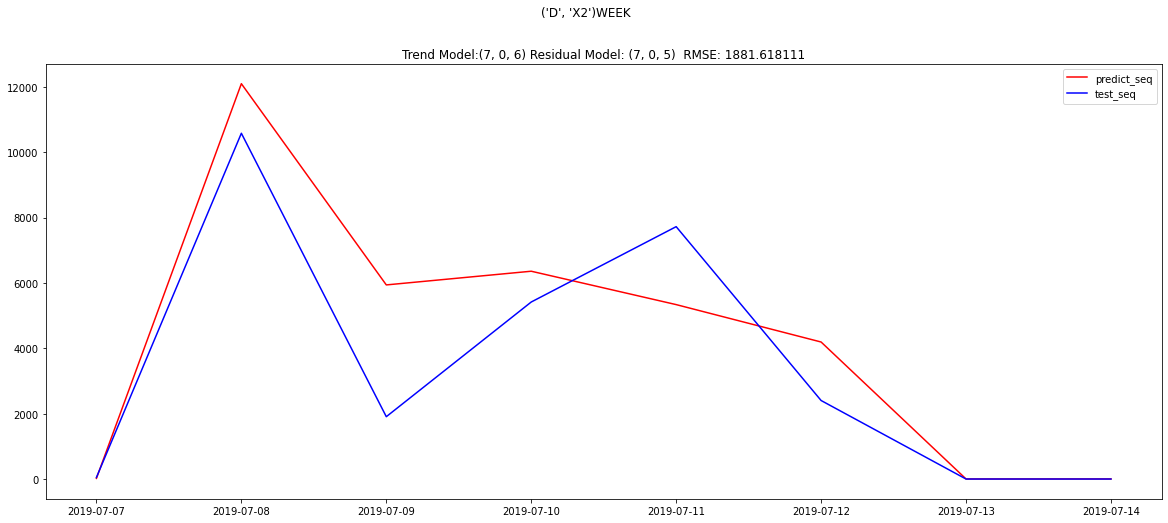

RMSE (0, 0, 0) 0.564970613635462
RMSE (0, 0, 1) 0.3782749733703101
RMSE (0, 0, 4) 0.27471264338050816
RMSE (0, 0, 6) 0.23947230652530857
RMSE (0, 0, 7) 0.23701259434133265
RMSE (3, 0, 6) 0.2368512613934256
RMSE (3, 0, 7) 0.23671078753468666
RMSE (4, 0, 6) 0.2365243145923694
RMSE (5, 0, 7) 0.2363812382394936
RMSE (6, 0, 7) 0.23611894988568946
RMSE (7, 0, 6) 0.23560927962095782
RMSE (0, 0, 0) 1.0550462442185526
RMSE (0, 0, 1) 1.0548631135624433
RMSE (0, 0, 2) 0.8587334643259285
RMSE (0, 0, 3) 0.8505223083663571
RMSE (1, 0, 5) 0.7496352891954063
RMSE (1, 0, 7) 0.7487197542386099
RMSE (6, 0, 4) 0.7462438059322334
32


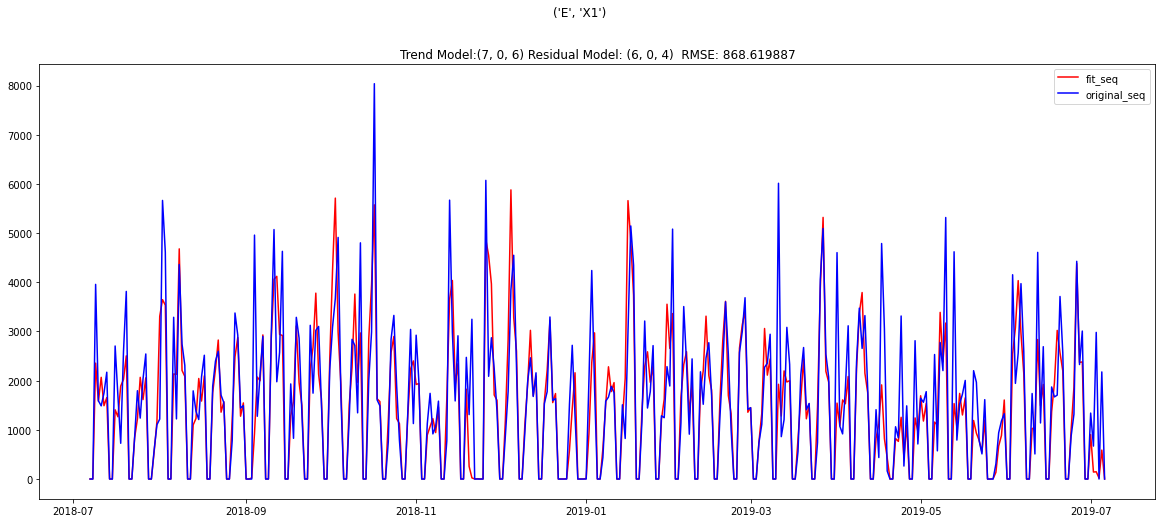

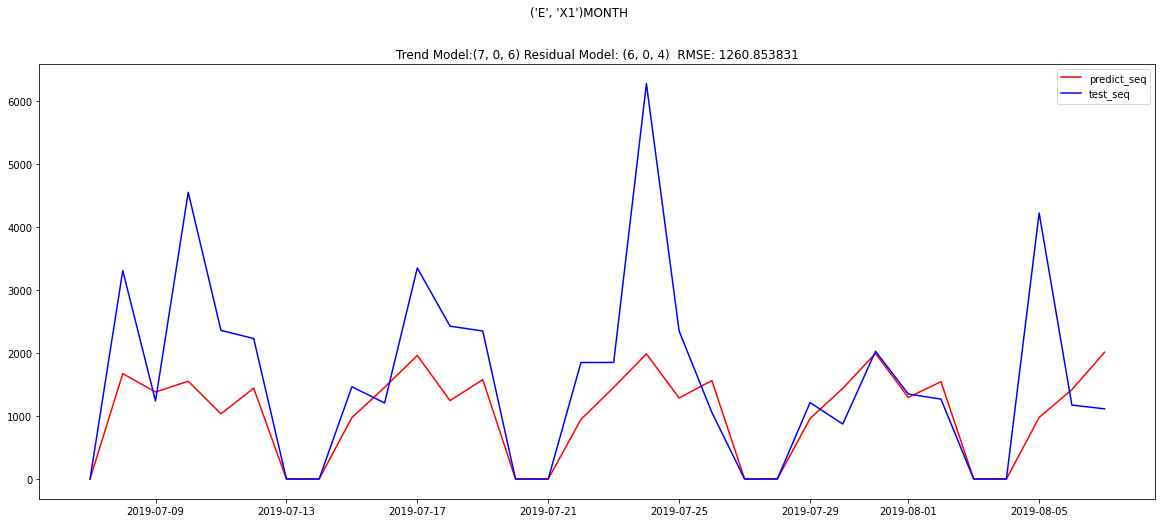

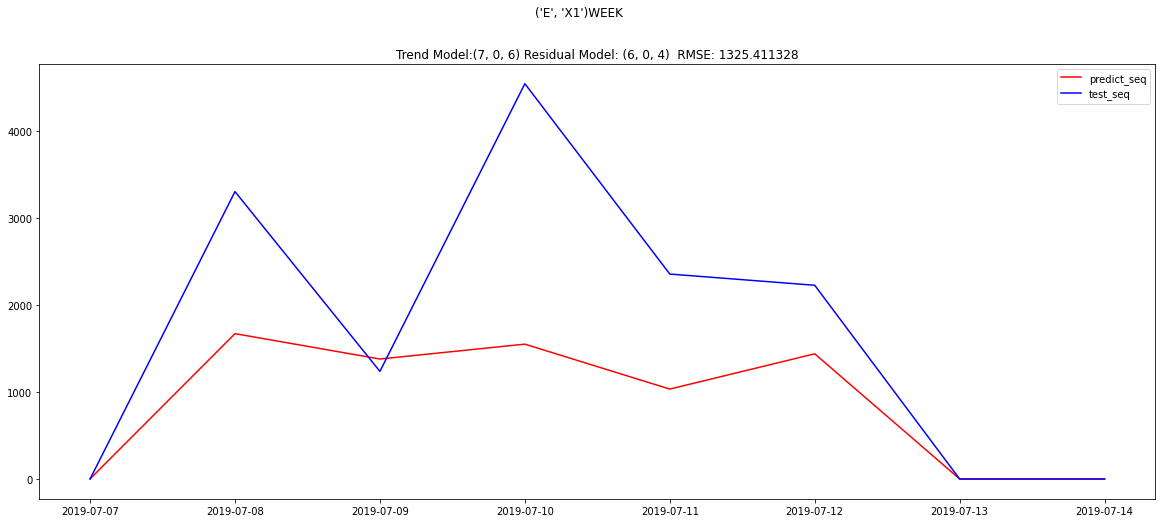

RMSE (0, 0, 0) 0.7219583536541225
RMSE (0, 0, 1) 0.5002618074489775
RMSE (0, 0, 3) 0.3825262276147947
RMSE (0, 0, 4) 0.38232925840119014
RMSE (0, 0, 5) 0.38206225280171285
RMSE (0, 0, 6) 0.33721239783640666
RMSE (7, 0, 6) 0.33710628105840434
RMSE (0, 0, 0) 1.3407830961799503
RMSE (0, 0, 1) 1.1798113122784275
RMSE (0, 0, 2) 1.077963054344844
RMSE (0, 0, 3) 1.0757918657801009
RMSE (1, 0, 5) 0.9542746151092034
RMSE (2, 0, 6) 0.9542699897394288
RMSE (6, 0, 3) 0.9534164596820207
RMSE (6, 0, 4) 0.9529392634714511
32


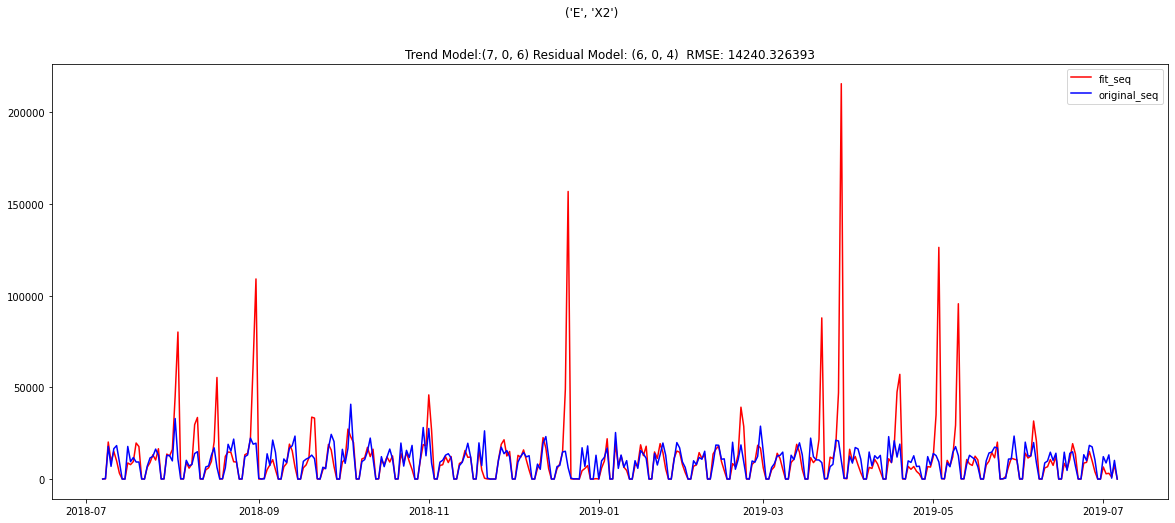

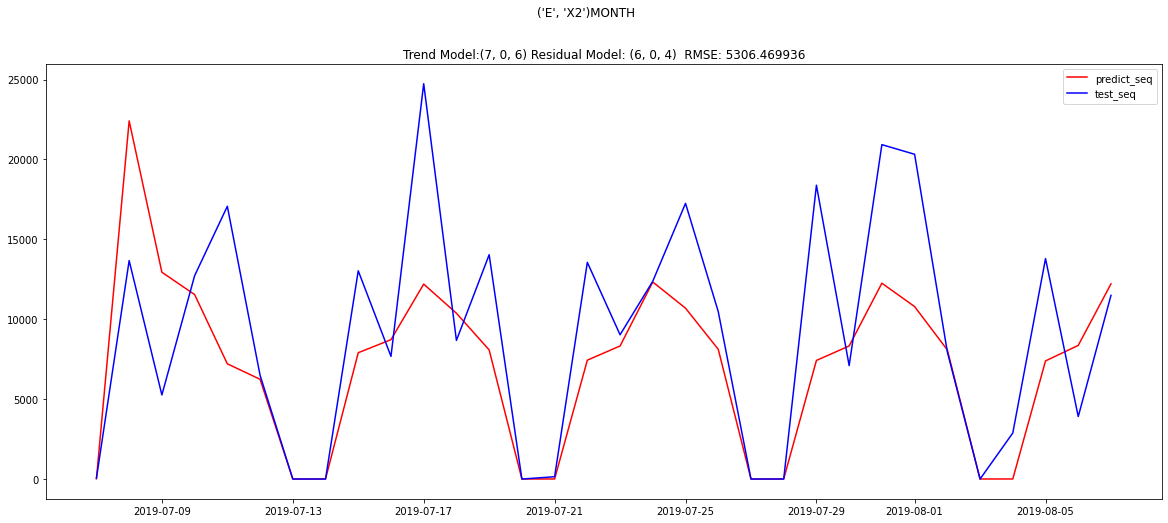

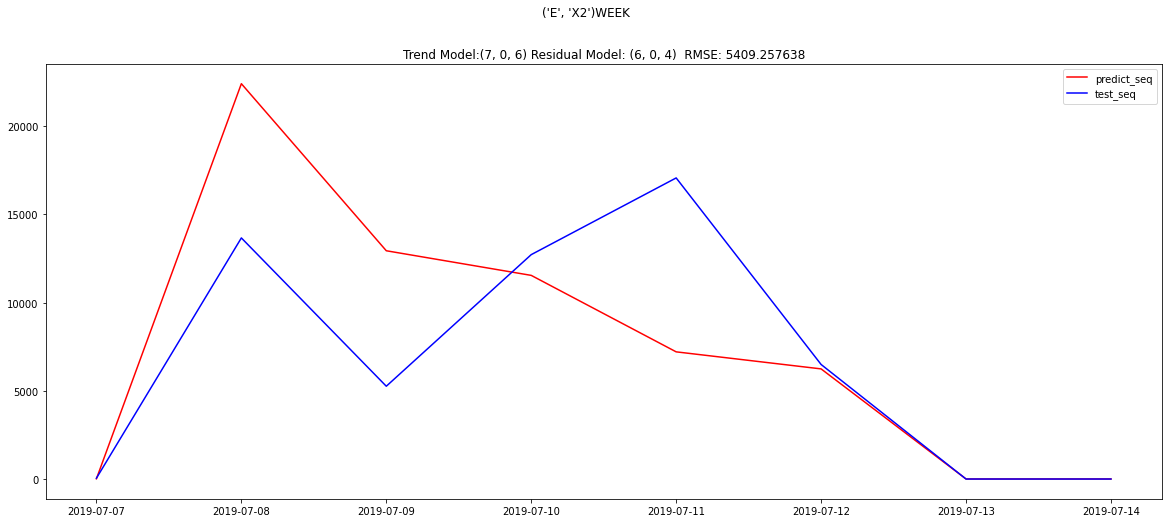

RMSE (0, 0, 0) 0.8422121664651131
RMSE (0, 0, 1) 0.5368814312664997
RMSE (1, 0, 0) 0.3207394174322781
RMSE (1, 0, 1) 0.3194310169034041
RMSE (1, 0, 2) 0.31931012830032823
RMSE (1, 0, 3) 0.3174242678075839
RMSE (1, 0, 4) 0.3073969919166995
RMSE (1, 0, 5) 0.30004159525567825
RMSE (1, 0, 6) 0.2533875334144085
RMSE (1, 0, 7) 0.2484892691266391
RMSE (2, 0, 7) 0.24837514560701252
RMSE (4, 0, 7) 0.24810380071305269
RMSE (5, 0, 7) 0.24809956117379706
RMSE (6, 0, 7) 0.24809357896661688
RMSE (7, 0, 7) 0.2480788256992308
RMSE (0, 0, 0) 1.5168983712289792
RMSE (0, 0, 1) 1.2732862442409703
RMSE (0, 0, 2) 1.1916183463611003
RMSE (0, 0, 3) 1.1908537471217668
RMSE (1, 0, 7) 1.073817251344802
RMSE (6, 0, 2) 1.071230659342604
32


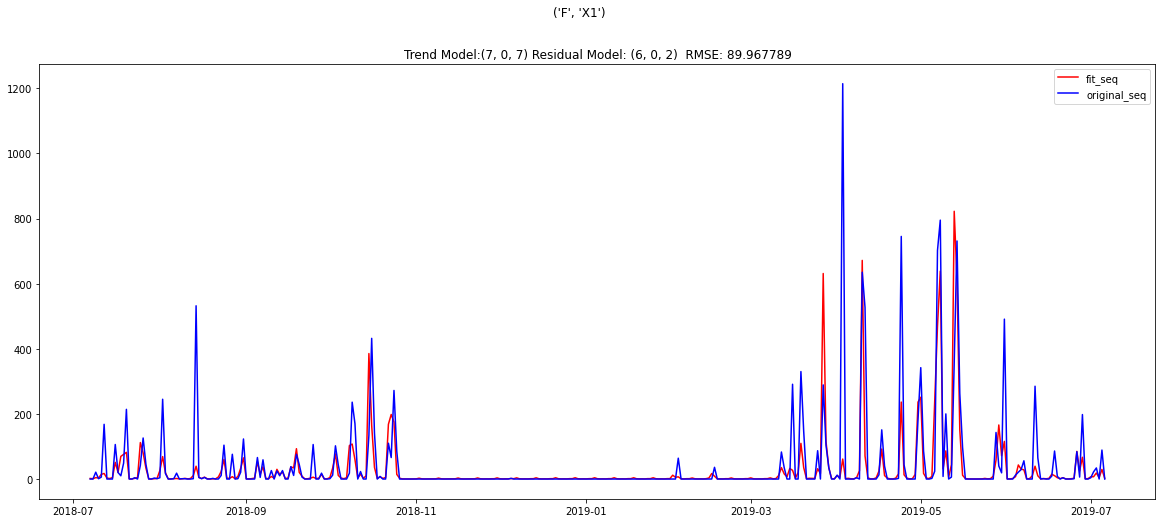

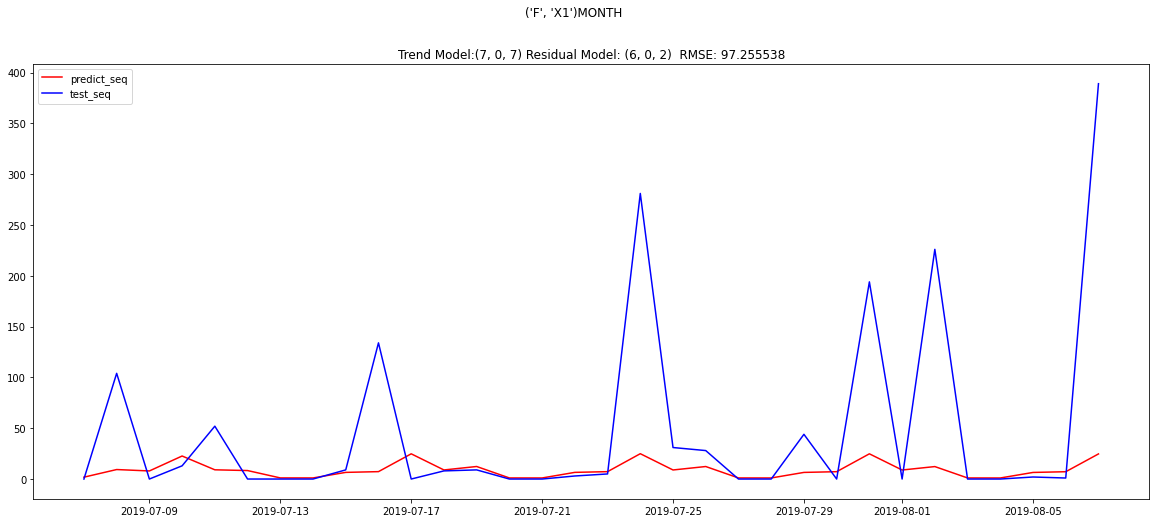

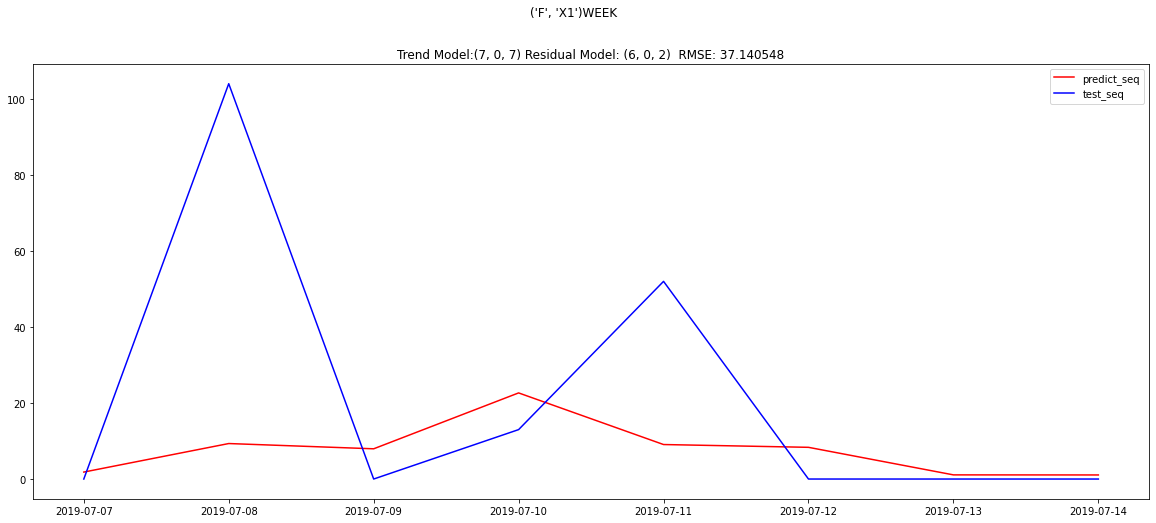

RMSE (0, 0, 0) 0.9608167825494053
RMSE (0, 0, 1) 0.6130712356264206
RMSE (0, 0, 2) 0.4780377855412385
RMSE (0, 0, 3) 0.388611022532953
RMSE (0, 0, 4) 0.3807826840484242
RMSE (0, 0, 5) 0.3807467095985738
RMSE (0, 0, 6) 0.2750786892225644
RMSE (0, 0, 7) 0.27286798899101516
RMSE (1, 0, 6) 0.27221836115127757
RMSE (1, 0, 7) 0.2599703611936214
RMSE (3, 0, 7) 0.2599394630802468
RMSE (4, 0, 7) 0.2599228939962476
RMSE (5, 0, 7) 0.2598637597669907
RMSE (7, 0, 7) 0.2598349485039969
RMSE (0, 0, 0) 1.6112916753835538
RMSE (0, 0, 1) 1.3636965582349534
RMSE (0, 0, 2) 1.2729485082468062
RMSE (0, 0, 3) 1.2727517688591576
RMSE (1, 0, 7) 1.1300862066304649
RMSE (5, 0, 2) 1.1278868525690493
RMSE (6, 0, 2) 1.1159473506692807
32


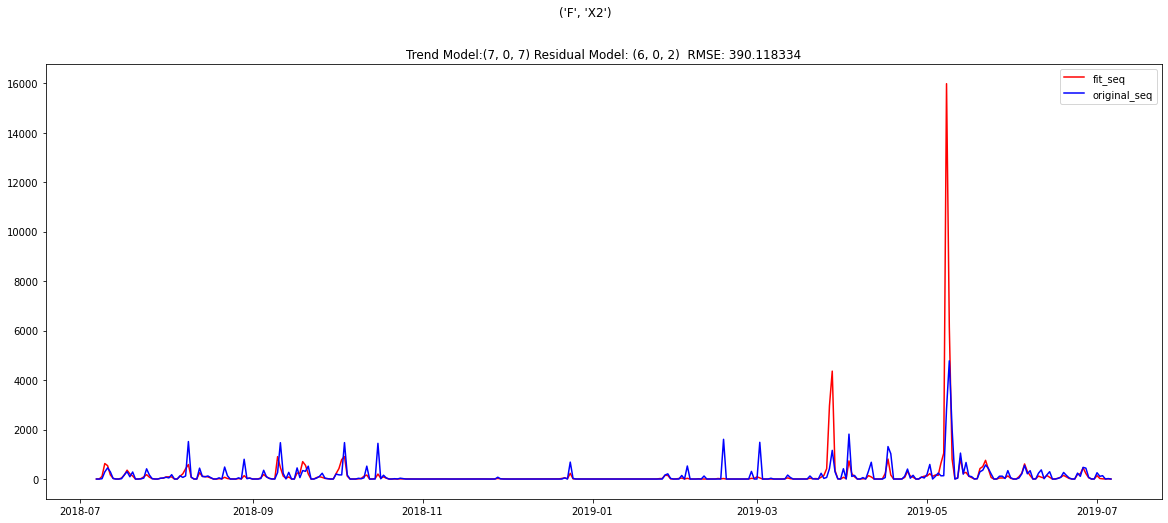

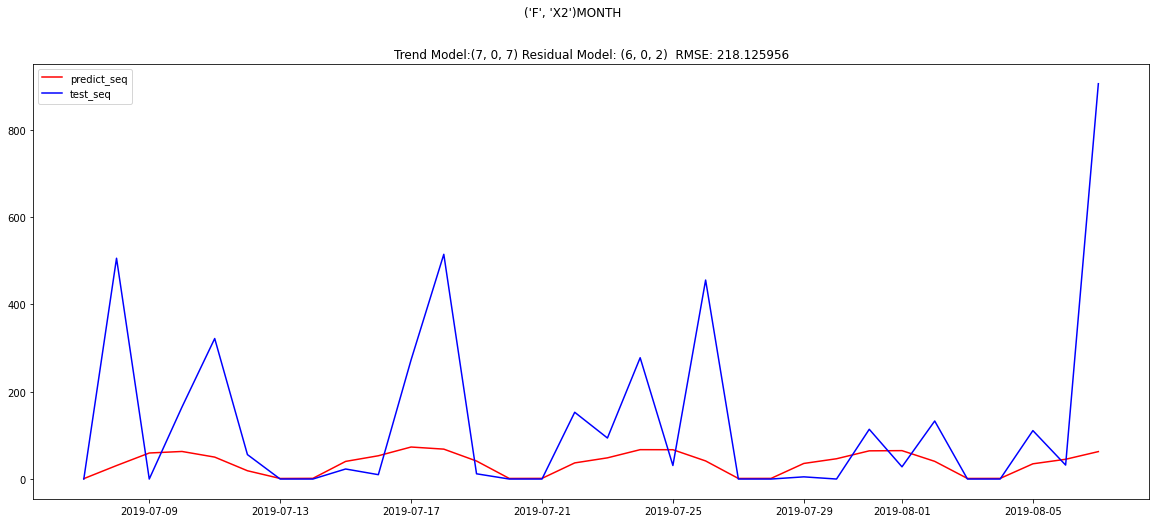

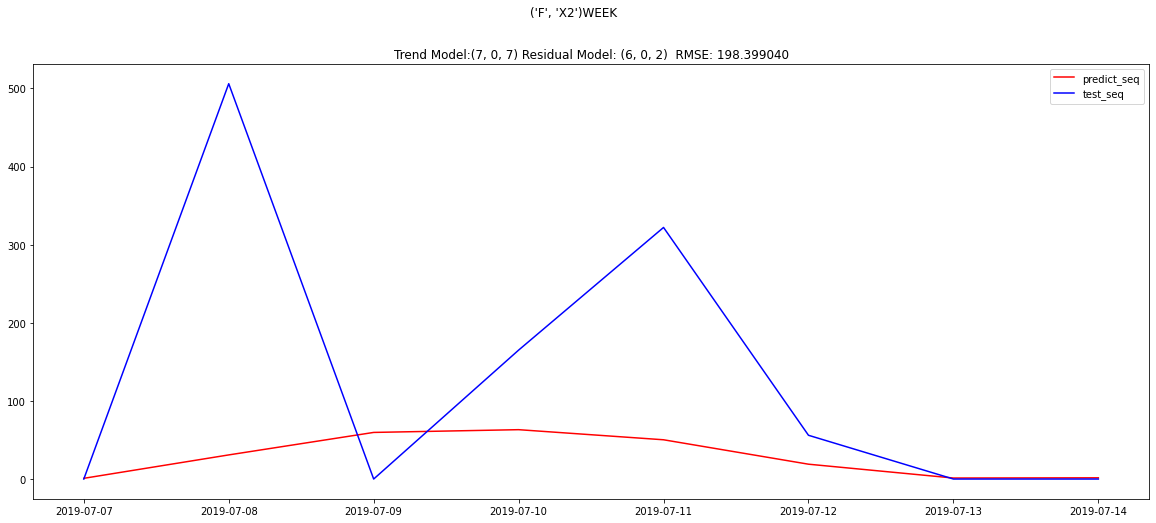

RMSE (0, 0, 0) 0.7379203875304049
RMSE (0, 0, 1) 0.5306353879676514
RMSE (0, 0, 2) 0.4623820083478449
RMSE (0, 0, 3) 0.4109894902561543
RMSE (0, 0, 4) 0.407836273456888
RMSE (0, 0, 5) 0.40781347003813756
RMSE (0, 0, 6) 0.296703064861246
RMSE (0, 0, 7) 0.2967029509261963
RMSE (1, 0, 6) 0.29670266716781996
RMSE (1, 0, 7) 0.296480243119958
RMSE (2, 0, 7) 0.2963985004725063
RMSE (3, 0, 7) 0.29632903685428935
RMSE (6, 0, 7) 0.29631984381515264
RMSE (7, 0, 6) 0.2960777969650539
RMSE (0, 0, 0) 1.9018991893583521
RMSE (0, 0, 1) 1.5723433599789942
RMSE (0, 0, 2) 1.492639068552154
RMSE (7, 0, 1) 1.3592664742812095
32


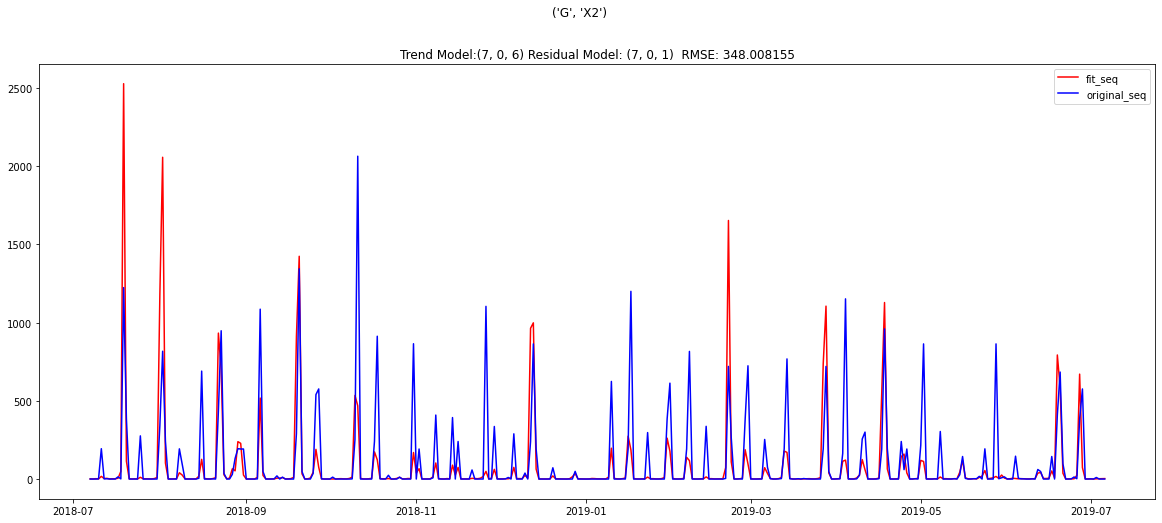

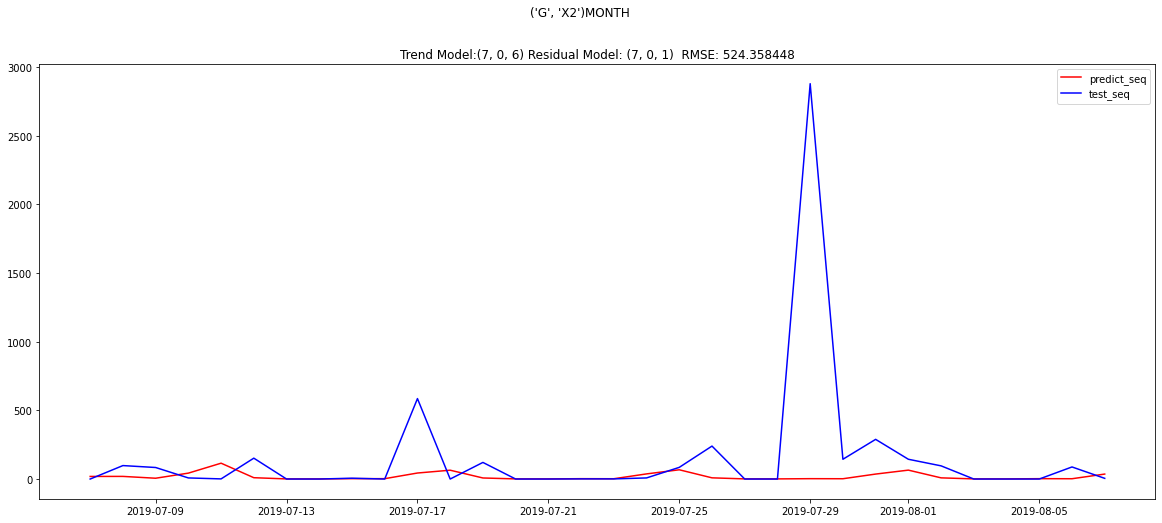

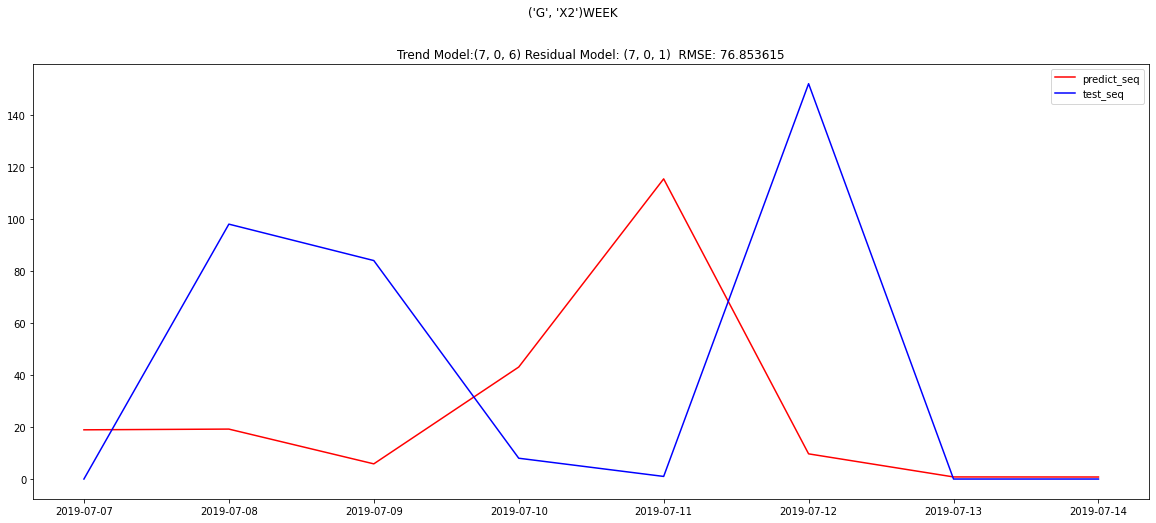

RMSE (0, 0, 0) 0.7092168232031871
RMSE (0, 0, 1) 0.44289282945503744
RMSE (0, 0, 3) 0.2709548159351192
RMSE (0, 0, 4) 0.26521966424511034
RMSE (1, 0, 0) 0.23734419258527936
RMSE (1, 0, 1) 0.23662816458556218
RMSE (1, 0, 2) 0.23531072795905641
RMSE (1, 0, 3) 0.23437267208928622
RMSE (1, 0, 5) 0.22193520778674367
RMSE (1, 0, 6) 0.19844535613516254
RMSE (1, 0, 7) 0.1907812053290999
RMSE (2, 0, 7) 0.19077209727163072
RMSE (3, 0, 7) 0.19032398810250262
RMSE (4, 0, 7) 0.18998850790468882
RMSE (5, 0, 7) 0.18925320520402064
RMSE (0, 0, 0) 1.0840523554776869
RMSE (0, 0, 1) 0.944456220474688
RMSE (0, 0, 2) 0.8733633026295214
RMSE (0, 0, 3) 0.8717568331938849
RMSE (1, 0, 6) 0.7963745605238447
RMSE (1, 0, 7) 0.7927137460757819
RMSE (3, 0, 7) 0.7879868836063384
RMSE (6, 0, 4) 0.7818621176867664
32


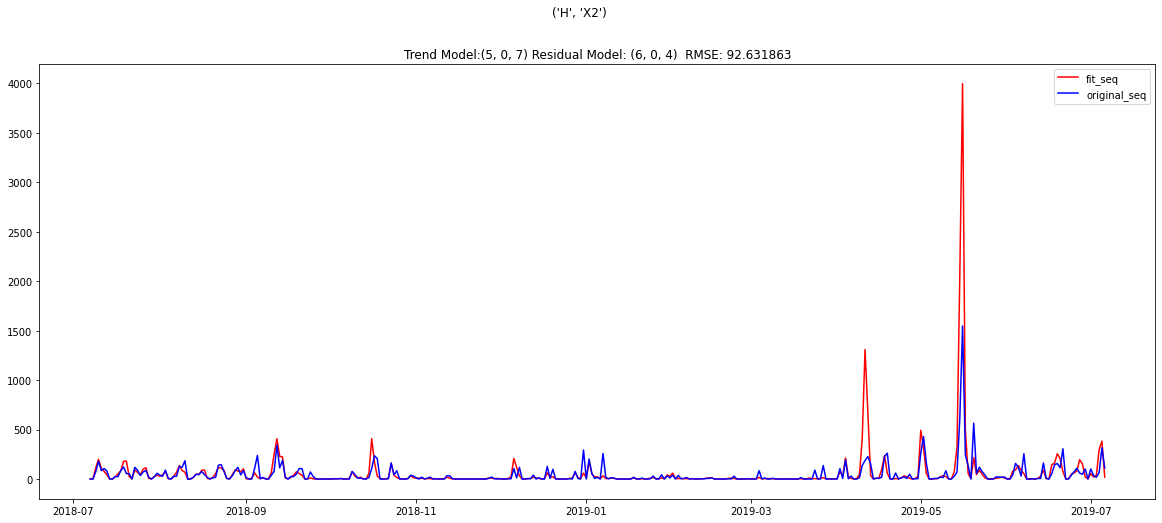

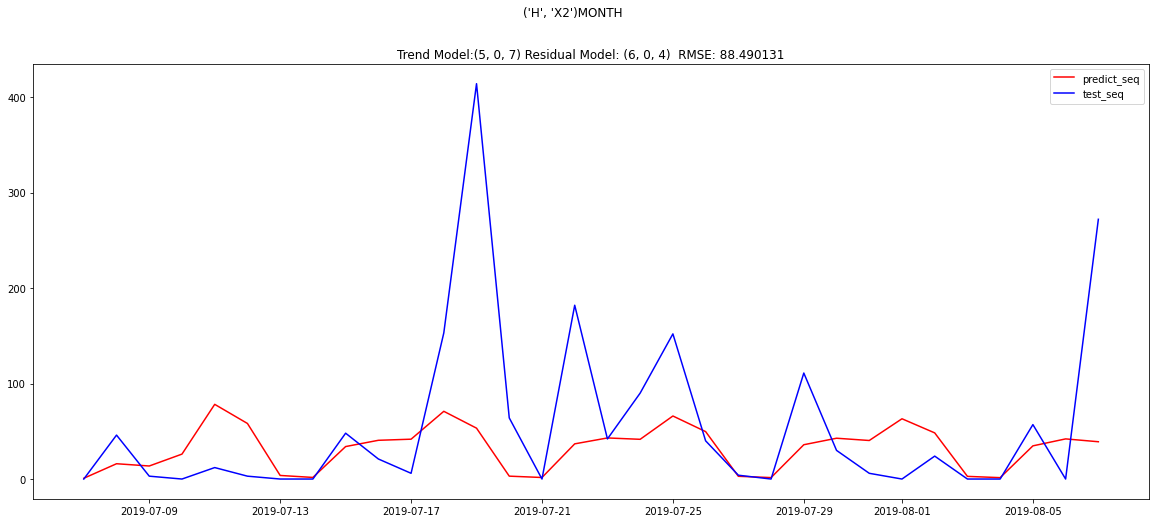

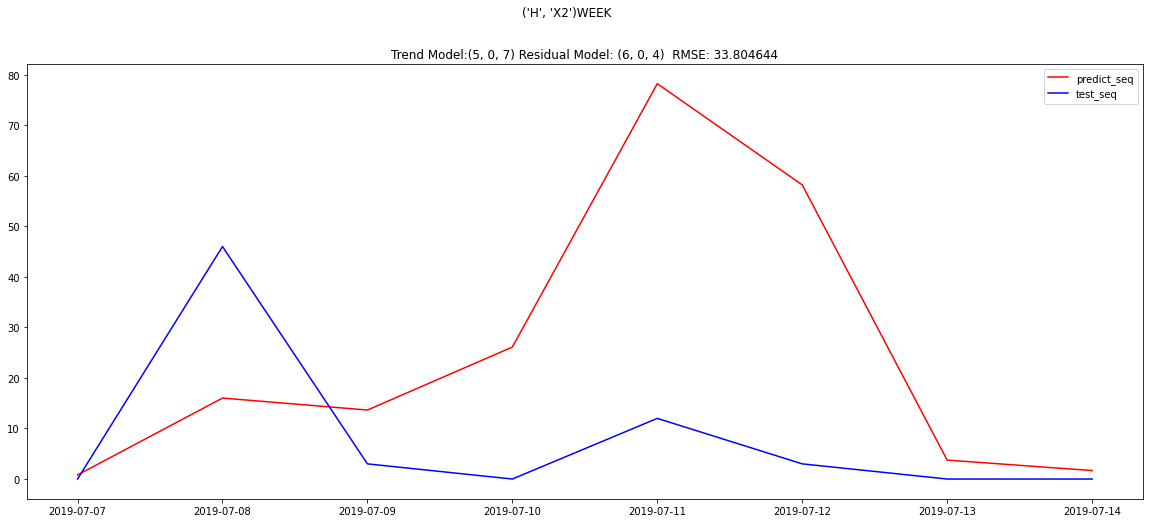

In [ ]:
residual_pdq=list()
trend_pdq=list()
model_info=pd.DataFrame(columns=['Label','Trend','Residual','Simulation_RMSE','Month_RMSE','Week_RMSE','Simulation_WAPE','Month_WAPE','Week_WAPE'])
index=0

for label,df in groups:
  if index<4:
    print(label)
    pass
  else:
    train_size=int(len(df)*0.9)
    
    data=df.iloc[:,2].astype('int').reset_index()

    data=df.iloc[:,2].astype('int').reset_index()
    work=workday.reset_index()
    df1=pd.concat([data,work],axis=1).iloc[:,1:]
    df1.set_index('DATE',inplace=True)
    df1.index.name=None
    data=df1.iloc[:,0]

    series=log(data)

    #series=data
    
    series.index=data.index.astype('datetime64[ns]')
    data.index=data.index.astype('datetime64[ns]')
    train=series[0:train_size]
    test=series[train_size:]
 
    decomposition = seasonal_decompose(series)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    trend = trend.fillna(0)
    seasonal = seasonal.fillna(0)
    residual = residual.fillna(0)

    tr_pdq=gridsearch(trend)
    re_pdq=gridsearch(residual)

    
    fit_seq,pre_seq=model_fit(seasonal,trend,residual,tr_pdq,re_pdq)
    
    #recover the log sequence
    fit_rec=recover(fit_seq)
    pre_rec=recover(pre_seq)

    rs,ws=fit_plot(fit_rec,label,data[0:train_size],tr_pdq,re_pdq)
    rm,wm=pre_month(pre_rec,label,data[train_size:],tr_pdq,re_pdq)
    rw,ww=pre_week(pre_rec[0:8],label,data[train_size:],tr_pdq,re_pdq)

    model_info.loc[index]=[label,tr_pdq,re_pdq,rs,rm,rw,ws,wm,ww]


    #recover the log sequence
   # week_fit_seq=recover(week_fit_seq)
    #week_pre_seq=recover(week_pre_seq)

    #plt.figure(figsize=(12, 6))
    #plt.plot(seasonal,label='Seasonarity')#all are 7
    #residual_p,residual_d,residual_q,residual_aic=gridsearch(residual)
  #break
  index+=1


In [ ]:
model_info.to_csv('/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/Model_info/ARIMAX_log(wrokday).csv')

NameError: ignored